## Some ideas for a numerical solution to the SPACE model: Stream Power with Alluvium Conservation and Entrainment

### THIS IS AN EVEN TINIER VERSION...

Basic equation set so far, for 1D. Sediment flux downstream:

$$\frac{dq_s}{dx} = K_s q S (1-\exp (-H/H_* ) ) + (1-F_f) K_r q S \exp (-H/H_*) -Vq_s/q$$

Rate of change of alluv thickness:

$$(1-\phi ) \frac{\partial H}{\partial t} = V q_s/q - K_s q S (1-\exp (-H/H_* ) )$$

Rate of change of rock elev:

$$\frac{\partial R}{\partial t} = U - K_r q S \exp (-H/H_* )$$

Local analytical solution for sediment flux within a cell:

$$q_s = \left( \frac{E_s+(1-F_f)E_r}{V/q} \right) \left( 1-\exp (-Vx/q) \right) + q_{s0} \exp (-Vx/q)$$

Try a little 1D version with some initial slope $S_0$:

In [88]:
import numpy as np

num_nodes = 2
dx = 1.0
S0 = 0.01
q = 1.0
V = 0.001
Ff = 0.5
Ks = 1.0
Kr = 0.001
Hstar = 1.0
Voverq = V / q
dt = 20.0
U = 1.0e-6

# handy array index
upper = np.arange(num_nodes - 1)

# arrays for qs, x, H, R, and z
qs = np.zeros(num_nodes)
qs_in = np.zeros(num_nodes)
x = dx * np.arange(0, num_nodes)
H = np.zeros(num_nodes)
R = np.zeros(num_nodes)
z = S0 * (num_nodes - 1) * dx - S0 * x
R[:] = z
z

array([ 0.01,  0.  ])

Calculate $E_s$ and $E_r$ for all nodes:

In [89]:
S = (z[upper] - z[1:]) / dx
Es = Ks * q * S * (1.0 - np.exp(-H[upper]/ Hstar))
Er = Kr * q * S * np.exp(-H[upper] / Hstar)
Er

array([  1.00000000e-05])

Now loop from upstream to downstream calculating flux:

In [90]:
for i in range(num_nodes - 1):
    qs[i] = ((Es[i] + (1-Ff) * Er[i]) / Voverq) * (1.0 - np.exp(-dx * Voverq)) + qs_in[i] * np.exp(-dx * Voverq)
    qs_in[i+1] = qs[i]
qs

array([  4.99750083e-06,   0.00000000e+00])

Now do a forward Euler solution for $H$:

In [91]:
deprate = qs[upper] * Voverq
print('deprate' + str(deprate))
Es = Ks * q * S * (1.0 - np.exp(-H[upper] / Hstar))
print('Es' + str(Es))
dHdt = deprate - Es
print('dHdt' + str(dHdt))
#H[upper] += dt * ((qs[upper] * Voverq) - Ks * q * S * (1.0 - np.exp(-H[upper] / Hstar))
H[upper] += dHdt * dt
H

deprate[  4.99750083e-09]
Es[ 0.]
dHdt[  4.99750083e-09]


array([  9.99500167e-08,   0.00000000e+00])

Now, rock erosion/uplift and elevations:

In [92]:
R[upper] += dt * (U - Kr * q * S * np.exp(-H[upper] / Hstar))
z = R + H
z

array([ 0.0098201,  0.       ])

Now loop this:

In [93]:
tt = 2000.0
nt = int(tt/dt)
Ht = np.zeros(nt)
for t in range(nt):
    for i in range(num_nodes - 1):
        qs[i] = ((Es[i] + (1-Ff) * Er[i]) / Voverq) * (1.0 - np.exp(-dx * Voverq)) + qs_in[i] * np.exp(-dx * Voverq)
        qs_in[i+1] = qs[i]
    deprate = qs[upper] * Voverq
    Es = Ks * q * S * (1.0 - np.exp(-H[upper] / Hstar))
    dHdt = deprate - Es
    #H[upper] += dt * ((qs[upper] * Voverq) - Ks * q * S * (1.0 - np.exp(-H[upper] / Hstar))
    H[upper] += dHdt * dt
    R[upper] += dt * (U - Kr * q * S * np.exp(-H[upper] / Hstar))
    z = R + H
    Ht[t] = H[0]
print('qs: ' + str(qs))
print('deprate' + str(deprate))
print('Es' + str(Es))
print('dHdt' + str(dHdt))
print('H')
print(H)
print('R')
print(R)
print('z')
print(z)

qs: [  5.00250083e-06   0.00000000e+00]
deprate[  5.00250083e-09]
Es[  5.00250083e-09]
dHdt[  1.07769226e-18]
H
[  5.00250208e-07   0.00000000e+00]
R
[-0.00817999  0.        ]
z
[-0.00817949  0.        ]


5.002502083989232e-07

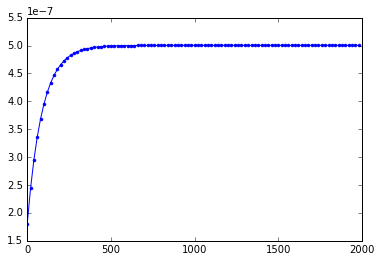

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(dt * np.arange(nt), Ht, '.-')
Ht[nt-1]